# Question 2 (50 points)
***In this question, you will simulate a peptide design experiment, trying to find peptides with high binding affinity to MHC class I using a bayesian optimization approach. Notice the goal here is not trying to find a peptide sequence that maximize the binding affinity to MHC, Since a sizable proportion of the sequence data we are using contains maximum binding affinity out of the data (9.0). Using the same feature encoding as question 1, we will examine several techniques to maximize the percentage of sequence with affinity of 9.0 for stringent querying.***

**TODO**
- **Complete the code under `### TO DO` in each cell and produce the required plots. Feel free to define any helper functions as you see fit.**

### Imports and Setup

In [13]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import RandomForestRegressor

from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI

from scipy import sparse

# import seqlogo

import copy

### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

# 2.0. Reading and Processing the Data

### Load Data

In [4]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


### Encode Data

In [5]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [6]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [7]:
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1)
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [8]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [14]:
# convert to numpy array
X_pool=sparse.csr_matrix.toarray(X_enc)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


# 2.1. Random Sampling (5 points) 

**TODO**
- **Create a random query strategy for randomly selecting a sample to query from the data. If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequence with binding affinity 9.0 found by the strategy. Do this for 200 sampling steps. This will serve as the baseline to compare with optimizator performance in section 2.2 and 2.3.**

In [29]:
def calculate_percent(n_attempts, optimal_idx):
    '''
    Measures the percentage of sequences with binding affinity 9.0 found by the strategy to this point.
    '''
    n_success = len(optimal_idx)
    percent = n_success / n_attempts
    return percent
   
    
print('test calculate_percent()')
test_n_attempts = 5
test_optimal_idx = [1,2]
assert calculate_percent(test_n_attempts, test_optimal_idx) == 0.4

test calculate_percent()


In [32]:
%%time
#?? remove from pool if selected. How to track index if it keeps changing?

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

optimal_idx_rand = []
history_rand = [0]  # history of success / attempts

### TO DO
n_queries = 200
for q in range(n_queries):
    
    # select random point 
    query_idx = np.random.choice(len(X_cp))

    # check if pIC50 meets requirements for retention
    if y_cp[query_idx] == 9.0:
        optimal_idx_rand.append(query_idx)
        
    # calculate percent of sequences found by the strategy
    percent = calculate_percent(q+1, optimal_idx_rand)
    history_rand.append(percent)

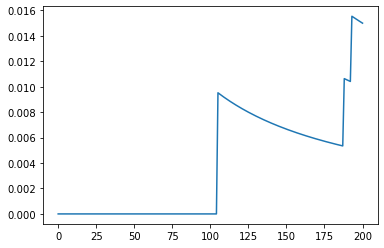

In [33]:
plt.plot(history_rand)
plt.show()

# 2.2. Baysian Optimization with Gaussian Process (15 points)

**TODO**
- **Create a Baysian optimizer with Gaussian process as regressor and Max Expected improvement as the queuing strategy.**
- **If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequence with binding affinity 9.0 found by the strategy.** 
- **Do this for 200 sampling steps.** 

**Hint: Check the modAL [documentation](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html#Optimizing-using-expected-improvement) for how to set up a Baysian optimizer.**

In [27]:
def get_next_sample(learner, X, y):
    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with d features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [45]:
%%time 
# 2.5 min

# ?? remove from pool

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

optimal_idx_gp = []
history_gp = [0]

### TO DO
# initialize learner
n_initial = 5
initial_idx = np.random.choice(range(len(X_cp)), size=n_initial, replace=False)
X_training, y_training = X_cp[initial_idx], y_cp[initial_idx]

# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
kernel = Matern(length_scale=1.0)

regressor = GaussianProcessRegressor(kernel=kernel)


# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# Bayesian optimization
n_queries = 200
for q in range(n_queries):

    # get sample
    X_sample, y_sample, query_idx = get_next_sample(optimizer, X_cp, y_cp)
    
    # check if sample meets criteria for saving
    if y_sample == 9.0:
        optimal_idx_gp.append(query_idx)
    
    # use new sample to update the model
    optimizer.teach(X_sample, y_sample)
    
    # calculate percent of sequences found by the strategy
    percent = calculate_percent(q+1, optimal_idx_gp)
    history_gp.append(percent)
    


CPU times: user 2min 30s, sys: 4.33 s, total: 2min 34s
Wall time: 46.2 s


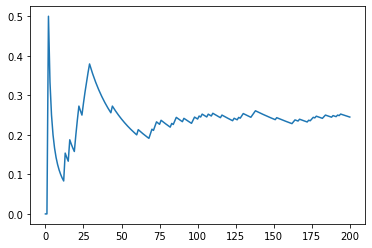

In [46]:
plt.plot(history_gp)
plt.show()

# 2.3. Bayesian Optimizer with Random Forest (10 points)

**Although Baysian optimization often uses the Gaussian process, Baysian optimizer in `modAL` can take any other regressor that has a predict function with a return_std input parameter. If return_std is set to `True`, the function returns the predicted values and standard deviation in the prediction.**

**TODO**
- **Create a Baysian optimizer with random forest regressor and Max Expected improvement as the queuing strategy.**
- **If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequences with binding affinity 9.0 found by the strategy.**
- **Do this for 200 sampling steps.**

**Hint: You might find the following class wrapper for random forest helpful.**

In [48]:
class RfWrapper(RandomForestRegressor):
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), np.std(ys, axis = 0).ravel()
        return super().predict(X).ravel()

In [ ]:
%%time 
# 2.5 min

# ?? remove from pool

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

optimal_idx_rf = []
history_rf = [0]

### TO DO
# initialize learner
n_initial = 5
initial_idx = np.random.choice(range(len(X_cp)), size=n_initial, replace=False)
X_training, y_training = X_cp[initial_idx], y_cp[initial_idx]



regressor = RfWrapper(RandomForestRegressor(n_estimators=20,max_depth=6,random_state=seed))


# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# Bayesian optimization
n_queries = 200
for q in range(n_queries):

    # get sample
    X_sample, y_sample, query_idx = get_next_sample(optimizer, X_cp, y_cp)
    
    # check if sample meets criteria for saving
    if y_sample == 9.0:
        optimal_idx_gp.append(query_idx)
    
    # use new sample to update the model
    optimizer.teach(X_sample, y_sample)
    
    # calculate percent of sequences found by the strategy
    percent = calculate_percent(q+1, optimal_idx_gp)
    history_gp.append(percent)
    

# 2.4: Plot Percentage of sequence with maximum binding affinity with respect to number of sequence queried (10 pts. total)

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6, 6), dpi=130)

ax.plot(history)
ax.scatter(range(len(history)), history, s=13, label = 'Baysian')


ax.plot(history_rf)
ax.scatter(range(len(history_rf)), history_rf, s=13, label = 'RF')


ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'Random')

ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Percentage of sequence with pIC50 = 9.0')
ax.legend()
plt.show()

# 2.5: Create sequence logo based on sequences found with each querying strategies (5 pts. total)

A sequence logo is a graphical representation of the sequence conservation of amino acids in protein sequences), as amino acids that are important for functions are likely to be conserved. Hence, a sequence logo is a way to visualize such an importance. Convert the each sets of sequences obtained by one of your optimization strategies to a sequence logo. Below is an example using all of the sequence of affinity 9.0.


$\textbf{Important}$: We are using <a href="https://pypi.org/project/seqlogo/"> seqlogo</a> to create sequence logo from our set of sequences. You can install seqlogo by entering the command 

conda install -c bioconda seqlogo 

in your conda terminal

In [ ]:
X_opt = X[np.where(y == 9)[0]]
ppm = np.sum(X_opt, axis = 0).reshape(20,9)
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type = 'AA')
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')

In [ ]:
### TO DO